# Cyber Developer Day 2024

## Introduction

Generative AI (GenAI) and Large Language Models (LLMs) are becoming essential tools in cybersecurity in part due to their ability to enhance the efficiency of cyber threat detection and response by accelerating analyst workflows. Prototyping and moving theses accelerated workflows into production can be daunting
Cybersecurity remains among the top three challenges impacting every industry—from the public sector to financial services, telecommunications, retail, automotive, and more. Most CEOs believe organizations with the most advanced generative AI capabilities will have a competitive advantage and are looking for ways to incorporate this into their business. Adversaries are already using generative AI in their attacks, however, and much more can be done to harness this power for cyberdefense. This hands-on tutorial will focus on accelerating an exploitablity analysis workflow to increase analyst productivity and enhance cybersecurity defenses.

### Problem Statement

Determining the impact of a documented Common Vulnerabilities and Exposures (CVE) on a specific project or container is a labor-intensive and manual task. This process involves the collection, comprehension, and synthesis of various pieces of information to ascertain whether immediate remediation, such as patching, is necessary upon the identification of a new CVE. Often, reasons cited for not updating a library affected by a CVE include the occurrence of scan false positives, the existence of mitigating factors, or the absence of necessary environments or dependencies for the exploit to be viable. Once an analyst has determined the library is not affected, a Vulnerability Exploitability eXchange (VEX) document must be created to standardize and distribute the results. The efficiency of this process can be significantly enhanced through the deployment of an event-driven LLM agent pipeline.

### Tutorial Goals

Our team developed a cybersecurity vulnerability analysis tool to aid in assessing the exploitability of CVEs in specific projects and containers. The following tutorial shows step-by-step how to leverage LLMs, RAG, and agents to create toy version and microservice running LLM-powered CVE exploitability analysis.
Students can experiment with the different modules to expand on this use case or leverage these modular pieces to construct a new pipeline of their own.

## Table of Contents

- [0 - Environment Setup](#0---Environment-Setup)
- [1 - Intro to Interacting with LLMs](#1---Intro-to-Interacting-with-LLMs)
  - [1.1 - Python Calls to LLM API](#1.1---Python-Calls-to-LLM-API)
  - [1.2 - Prompt Engineering](#1.2---Prompt-Engineering)
  - [1.3 - Prompt Templating](#1.3---Prompt-Templating)
  - [1.4 - One-Shot Learning](#1.4---One-Shot-Learning)
  - [1.5 - Few-Shot Learning](#1.5---Few-Shot-Learning)
  - [1.6 - Evaluation Strategies](#1.6---Evaluation-Strategies)
- [2 - Prototyping](#2---Prototyping)
  - [2.1 - Overview](#21---overview)
  - [2.2 - Building the Vector Database](#22---building-the-vector-database)
  - [2.3 - Running a RAG pipeline with Morpheus](#23---running-a-rag-pipeline-with-morpheus)
  - [2.4 - Running the CVE Pipeline with Morpheus](#24---running-the-cve-pipeline-with-morpheus)
- [3 - Beyond Prototyping](#3---Beyond-Prototyping)
  - [3.1 - Improving the Model](#31---improving-the-model)
  - [3.2 - Scaling the Pipeline](#32---scaling-the-pipeline)
  - [3.3 - Event Driven Pipeline: Creating a Microservice](#33---event-driven-pipeline-creating-a-microservice)

<div class="alert alert-block alert-info">
<b>Note:</b> Please continue running the notebook up to Part 1 during the introduction presentation to ensure your environment is set up correctly.
</div>


---


## 0 - Environment Setup


The following code blocks are used to setup environment variables and imports for the rest of the notebook.


In [5]:
%load_ext autoreload
%aimport -logging
%autoreload 2

# Ensure that the morpheus directory is in the python path. This may not need to be run depending on the environment setup
import sys
import os

if ("MORPHEUS_ROOT" not in os.environ):
    os.environ["MORPHEUS_ROOT"] = os.path.abspath("../../..")

llm_dir = os.path.abspath(os.path.join(os.getenv("MORPHEUS_ROOT", "../../.."), "examples", "cyber_dev_day"))

if (llm_dir not in sys.path):
    sys.path.append(llm_dir)


Ensure the necessary environment variables are set. As a last resort, try to load them from a `.env` file.


In [6]:
# Ensure that the current environment is set up with API keys
required_env_vars = [
    "MORPHEUS_ROOT",
    "NGC_API_KEY",
    "NVIDIA_API_KEY",
]

if (not all([var in os.environ for var in required_env_vars])):

    # Try loading an .env file if it exists
    from dotenv import load_dotenv

    load_dotenv()

    # Check again
    if (not all([var in os.environ for var in required_env_vars])):
        raise ValueError(f"Please set the following environment variables: {required_env_vars}")

Import some common libraries to allow them to be used later in the notebook.


In [7]:
import logging
import os
import time
from textwrap import wrap

import pandas as pd
from nemollm.api import NemoLLM

import cudf

# Finally, ensure Morpheus is installed correctly
import morpheus._lib

Configure logging to allow Morpheus messages to appear in the notebook.


In [8]:
# Configure logging
import cyber_dev_day

# Create a logger for this module. Use the cyber_dev_day module name because the notebook will just be __main__
logger = logging.getLogger(cyber_dev_day.__name__)

# Configure the parent logger log level
logger.parent.setLevel(logging.INFO)

Finally, test out the logger to ensure that it is working correctly. You should see a message printed to the console.


In [9]:
logger.info("Successfully configured logging!")

Successfully configured logging!


---

<div class="alert alert-block alert-warning">
<b>Note:</b> Please wait here until instructed to continue with running Part 1 of the notebook.
</div>


## 1 - Intro to Interacting with LLMs

This section will go over how to integrate LLMs into code with Python based examples. We will highlight some of the basic techniques for using and improving calls to LLMs for cybersecurity use cases.

1. Python calls to LLM API
2. Prompt engineering
3. Prompt templating
4. One-shot learning
5. Multi-shot learning

In this lab, we will be using [NVIDIA NeMo](https://www.nvidia.com/en-us/ai-data-science/generative-ai/nemo-framework/) as our generative AI platform. NeMo is a cloud-native framework for building, customizing and deploying generative AI models with a familiar ChatGPT-like interface. Utilizing NeMo (or any other generative AI service) in our pipelines allows us to offload the heavy lifting of language model inference to a dedicated service, freeing up our own resources for other tasks. All requests to the NeMo service are made via an HTTP API, which allows us to easily integrate it into our existing codebase.

To simplify the process of interacting with the NeMo service, the NeMo team provides a Python client library (`nemollm`) that wraps the HTTP API. This library provides a simple interface for making requests to the NeMo service, and handles the details of making HTTP requests and parsing the responses. This allows us to focus on the high-level logic of our application, rather than the low-level details of making HTTP requests.

Before sending requests to the NeMo service, we need to set up a NeMo connection object, `conn` which is shown below. We will use the `generate()` method of the connection object to send requests to the NeMo service for the remainder of this section.


In [10]:
# Create the connection object. The API key and organization ID are read from the environment variables NGC_API_KEY and
# NGC_ORG_ID respectively
conn = NemoLLM(api_host=os.getenv("NGC_API_BASE", None))

### 1.1 - Python Calls to LLM API

<dl>
<dt><b>Use Case</b></dt>
<dd>General cyber knowledge assistant, productivity tool to aid cyber analysts.</dd>
<dt><b>Query</b></dt>
<dd><code>In general, how can I determine if my specific environment is affected by a CVE?</code></dd>
</dl>


In [11]:
conn.generate(
    prompt="In general, how can I determine if my specific environment is affected by a CVE?",
    model="gpt-43b-002",
    tokens_to_generate=128,
    temperature=0,
    top_k=1,
    return_type="text",
)

' The best way to determine if your specific environment is affected by a CVE is to check the CVE entry for the vulnerability. The CVE entry will contain information about the vulnerability, including its severity, affected versions, and any available patches or mitigations. You can search for the CVE on the CVE List website, which is maintained by the MITRE Corporation.\n\nIf you are unable to find information about the vulnerability on the CVE List website, you can also check the websites of the vendors who provide the software or hardware that you are using. Vendors often release information about vulnerabilities that affect their products, including whether a patch or mitigation is available.'

#### 1.1.1 - Explore On Your Own: Different Models

Try another model such as `gpt-8b-000` `gpt20b` or `llama-2-70b-hf`


In [12]:
# TODO: Do we remove the filled out section here?
conn.generate(
    prompt="In general, how can I determine if my specific environment is affected by a CVE?",
    model="llama-2-70b-hf",
    tokens_to_generate=128,
    temperature=0,
    return_type="text",
)

"\nI'm trying to determine if my specific environment is affected by a CVE.\nI'm not sure if I'm asking the right question, but I'm trying to determine if my specific environment is affected by a CVE.\nI'm not sure if I'm asking the right question, but I'm trying to determine if my specific environment is affected by a CVE. I'm not sure if I'm asking the right question, but I'm trying to determine if my specific environment is affected by a CVE.\nI'm not sure if I'm asking the"

#### 1.1.2 - Explore On Your Own: Model Parameters

How do the different models compare? Can you change the parameters (like `temperature` or `repetition_penalty`) to help the smaller models improve?

What are some other cybersecurity questions you could ask an LLM to upskill a junior analyst?

---


Try few temperature values `temperature=[0.0, 0.5, 0.7, 0.9]` and higher value of `1<top_k<64` such as `[2, 10, 30]` parameter to make the model creative with its response. Higher values of the `top_k` enables the model to sample from next `k` probable token. If `top_k=1`, greedy sampling is used, what happen to model output with change in `temp`?

In [13]:
# # UNCOMMENT to try different parameters
# # Analyze output of the model for different value of temperature and top_k
# for temp in [0.0, 0.5, 0.7, 0.9]:
#     print(conn.generate(
#     prompt="In general, how can I determine if my specific environment is affected by a CVE?",
#     model="gpt-43b-002",
#     tokens_to_generate=100,
#     temperature=temp,
#     return_type="text",
#     top_k=10
#     ))
#     print("----")
    

### 1.2 - Prompt Engineering

Some tips for improving performance using prompt engineering can be found here https://www.promptingguide.ai/introduction/tips.

<dl>
<dt><b>Use Case</b></dt>
<dd>General cyber knowledge assistant, productivity tool to aid cyber analysts.</dd>
<dt><b>Persona</b></dt>
<dd>You are a helpful cybersecurity analyst with an IQ of 140.</dd>
<dt><b>Query</b></dt>
<dd><code>In general, how can I determine if my specific environment is vulnerable to a CVE?</code></dd>
</dl>


In [14]:
formatted_prompt = "{persona} {query}".format(
    persona="You are helpful cybersecurity expert with an IQ of 140.",
    query="In general, how can I determine if my specific environment is vulnerable to a CVE?")

conn.generate(
    prompt=formatted_prompt,
    model="gpt-43b-002",
    tokens_to_generate=256,
    temperature=0,
    return_type="text",
)

" The first step in determining if your specific environment is vulnerable to a CVE is to identify the affected software or system. Once you have identified the affected software or system, you can then check the vendor's website or security bulletin to see if a patch or update is available. If a patch or update is available, you should install it as soon as possible to mitigate the vulnerability.\n\nIf a patch or update is not available, you can try to determine if your specific environment is vulnerable by using a tool such as Nessus or OpenVAS to scan your network for the presence of the vulnerability. If the tool detects the vulnerability, you should take immediate action to mitigate it.\n\nIt's important to note that even if a vulnerability is not present in your specific environment, it may still be present in other environments that are connected to yours, such as third-party services or suppliers. Therefore, it's important to keep up to date with the latest security news and ad

#### _Explore on your own_

##### Does the persona improve performance?

##### What happens if you change the persona or attributes such as IQ?


In [15]:
## Try to change the content of persona and rerun the above code. 
# E.g. 
# persona = "You are helpful cybersecurity expert with an IQ of 40.",
# persona = "You are helpful data analyst with experience in analyzing vulnerabilites"


---


### 1.3 - Prompt Templating

including prompt template to include specific CVE context for the model

Can our LLM help with specific CVEs?

`Query: "How can I determine if my specific environment is affected by CVE-2023-47248?`


In [16]:
formatted_prompt = "{persona} {query}".format(
    persona="You are helpful cybersecurity expert with an IQ of 140.",
    query="How can I determine if my specific environment is affected by CVE-2023-47248?")

conn.generate(
    prompt=formatted_prompt,
    model="gpt-43b-002",
    tokens_to_generate=256,
    temperature=0,
    return_type="text",
)

" I'm sorry, but as a language model AI, I cannot access real-time information about specific cybersecurity threats. However, I can provide you with general guidance on how to stay safe online. Here are some tips:\n\n1. Keep your software and operating system up to date with the latest security patches.\n2. Use strong and unique passwords for each account, and consider using a password manager.\n3. Enable two-factor authentication (2FA) wherever possible.\n4. Be cautious of suspicious emails, texts, and phone calls, and never click on links or download attachments from unknown sources.\n5. Regularly back up your important data to an external drive or cloud storage service.\n6. Install and regularly update antivirus and anti-malware software on your devices.\n7. Be aware of phishing scams, which attempt to trick you into providing sensitive information or downloading malware.\n\nBy following these general security measures, you can help protect yourself from a wide range of cyber threat

##### What are some methods to get up-to-date CVE knowledge to our model?

##### Can we add it to the prompt?


In [17]:
prompt_template = """Generate a checklist for a security analyst to use when assessing the exploitability of a specific CVE within a containerized environment. \
For each checklist item, start with an action verb, making it clear and actionable. Provide the checklist as a Python list of strings. \
Utilize the provided CVE details below to tailor the checklist items specifically for this CVE.
CVE Details:
- CVE ID: {cve}
- Description: {cve_description}
- Vulnerable Package Name: {vuln_package}
- Vulnerable Package Version: {vuln_package_version}
- CVSS3 Vector String: {cvss3}"""

PYARROW_CVE_INTEL = dict(
    cve="CVE-2023-47248",
    cve_description="Deserialization of untrusted data in IPC and Parquet readers in PyArrow versions 0.14.0 to 14.0.0 "
    "allows arbitrary code execution. An application is vulnerable if it reads Arrow IPC, Feather or Parquet data from untrusted sources "
    "(for example user-supplied input files). This vulnerability only affects PyArrow, not other Apache Arrow implementations or bindings. "
    "It is recommended that users of PyArrow upgrade to 14.0.1. Similarly, it is recommended that downstream libraries upgrade their dependency "
    "requirements to PyArrow 14.0.1 or later. PyPI packages are already available, and we hope that conda-forge packages will be available soon. "
    "If it is not possible to upgrade, we provide a separate package `pyarrow-hotfix` that disables the vulnerability on older PyArrow versions. "
    "See https://pypi.org/project/pyarrow-hotfix/ for instructions.",
    vuln_package="PyArrow",
    vuln_package_version="0.14.0 through 14.0.1",
    cvss3="CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H")

formatted_prompt = prompt_template.format(**PYARROW_CVE_INTEL)

print(
    conn.generate(
        prompt=formatted_prompt,
        model="gpt-43b-002",
        tokens_to_generate=256,
        temperature=0,
        return_type="text",
    ))

 - Check if the containerized environment uses PyArrow 0.14.0 through 14.0.1.
- If yes, check if the containerized environment reads Arrow IPC, Feather, or Parquet data from untrusted sources.
- If yes, check if the containerized environment upgrades to PyArrow 14.0.1.
- If no, check if the containerized environment downgrades to PyArrow 14.0.1 or later.
- If no, check if the containerized environment uses the pyarrow-hotfix package to disable the vulnerability.


##### Is this a useful planning step and thought process?

##### Did the model generate the checklist/task list as a python list of strings as we requested?

##### Do other models work better?


In [18]:
models_to_try = ['gpt5b', 'gpt-8b-000', 'gpt20b', 'gpt-43b-002', 'llama-2-70b-hf']

for model in models_to_try:
    model_output = conn.generate(
        prompt=formatted_prompt,
        model=model,
        tokens_to_generate=256,
        temperature=0,
        top_k=1,
        return_type="text",
    )
    print(f"Model: {model}\n{model_output}\n\n")

Model: gpt5b

- CVSS3 Base Score: 7.8
- CVSS3 Vector: (AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H)
- CVSS3 Severity: High
- CVSS3 Vector: (AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H)
- CVSS3 Base Score: 7.8
- CVSS3 Vector: (AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H)
- CVSS3 Severity: High
- CVSS3 Vector: (AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H)
- CVSS3 Base Score: 7.8
- CVSS3 Vector: (AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H)
- CVSS3


Model: gpt-8b-000

- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H
- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H
- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H
- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H
- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H
- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N


Model: gpt20b

- CVSS3 Base Score: 7.5
- CVSS3 Temporal Score: 7.5
- CVSS3 Exploitability Score: 7.5
- CVSS3 Impact Score: 7.5
- CVSS3 Confidence Interval: 7.5
- CVSS3 Base Vector:

##### How can we check the model's accuracy?


In [19]:
import ast


# we can evaulate if the checklist is properly formatted using this function
def is_properly_formatted_list(checklist):
    try:
        # Attempt to evaluate checklist as a Python literal
        evaluated_checklist = ast.literal_eval(checklist)

        # Check if the evaluated object is a list
        if isinstance(evaluated_checklist, list):
            print("Checklist is properly formatted.")
            return True
        else:
            print("Checklist is not a list.")
            return False
    except ValueError as e:
        # Handle the case where checklist cannot be evaluated as a Python literal
        print(f"Checklist is not properly formatted: {e}")
        return False
    except SyntaxError as e:
        # Handle syntax errors in the checklist string
        print(f"Checklist has a syntax error: {e}")
        return False

In [20]:
is_properly_formatted_list(
    conn.generate(
        prompt=formatted_prompt,
        model="gpt-43b-002",
        tokens_to_generate=256,
        temperature=0,
        return_type="text",
    ))

Checklist has a syntax error: expected 'else' after 'if' expression (<unknown>, line 1)


False

##### How can we improve performance?


<hr>

### 1.4 - One-Shot Learning

Adding an example into the prompt can improve results.


You are an expert secuirty analyst. Your objective is to add a "Checklist" section containing steps to use when assessing the exploitability of a specific CVE within a containerized environment. \
For each checklist item, start with an action verb, making it clear and actionable

**Context**:
Not all CVEs are exploitable in a given container. By making a checklist specific to the information available for a given CVE analysts can execute the checklist to determine exploitability.

**Example Format**:
Below is a format for examples that illustrate transforming CVE information into an exploitability assessment checklist.

Example CVE Details:

- CVE ID: CVE-2022-2309
- Description: NULL Pointer Dereference allows attackers to cause a denial of service (or application crash). This only applies when lxml up to version 4.9.1 \
  is used together with libxml2 2.9.10 through 2.9.14. libxml2 2.9.9 and earlier are not affected. It allows triggering crashes through forged input data, given a
  vulnerable code sequence in the application. The vulnerability is caused by the iterwalk function (also used by the canonicalize function). Such code shouldn't be
  in wide-spread use, given that parsing + iterwalk would usually be replaced with the more efficient iterparse function. However, an XML converter that serialises to \
  C14N would also be vulnerable, for example, and there are legitimate use cases for this code sequence. If untrusted input is received (also remotely) and processed via \
  iterwalk function, a crash can be triggered.
- Vulnerable Package Name: lxml, libxml2
- Vulnerable Package Version: lxml: up to 4.9.1, libxml2: 2.91.0 through 2.9.14
- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H

Example Exploitability Assessment Checklist: \
[
"Check for lxml: Verify if your project uses the lxml library, which is the affected package. If lxml is not a dependency in your project, then your code is not vulnerable to this CVE.",
"Review Affected Versions: If lxml is used, checked the version that your project depends on. According to the vulnerability details, versions 4.9.0 and earlier are vulnerable.",
"Review Versions of Connected Dependencies: The package is only vulnerable if libxml 2.9.10 through 2.9.14 is also present. Check the version of libxml in the project.",
"Check for use of vulnerable functions: The library is vulnerable through its `iterwalk` function, which is also utilized by the `canonicalize` function. Check if either of these functions are used in your code base."
]

**Criteria**:

- Exploitability assessment checklists must relate to the information in the specific CVE Details.

**Procedure**:
[
"Understand the CVE Details, description, and CVSS3 attack vector string.",
"Produce a CVE exploitability assessment checklist.",
"Format the checklist as comma separated list surrounded by square braces.",
"Output the checklist."
]

**CVE Details:**

- CVE ID: {cve} \
- Description: {cve_description} \
- Vulnerable Package Name: {vuln_package} \
- CVSS3 Vector String: {cvss3}"

**Checklist**:


In [21]:
one_shot_prompt_template = """You are an expert secuirty analyst. Your objective is to add a "Checklist" section containing steps to use when assessing the exploitability of a specific CVE within a containerized environment. \
For each checklist item, start with an action verb, making it clear and actionable

**Context**:
Not all CVEs are exploitable in a given container. By making a checklist specific to the information available for a given CVE analysts can execute the checklist to determine exploitability.

**Example Format**:
Below is a format for examples that illustrate transforming CVE information into an exploitability assessment checklist.

Example CVE Details:
- CVE ID: CVE-2022-2309 \
- Description: NULL Pointer Dereference allows attackers to cause a denial of service (or application crash). This only applies when lxml up to version 4.9.1 \
is used together with libxml2 2.9.10 through 2.9.14. libxml2 2.9.9 and earlier are not affected. It allows triggering crashes through forged input data, given a
vulnerable code sequence in the application. The vulnerability is caused by the iterwalk function (also used by the canonicalize function). Such code shouldn't be
in wide-spread use, given that parsing + iterwalk would usually be replaced with the more efficient iterparse function. However, an XML converter that serialises to \
C14N would also be vulnerable, for example, and there are legitimate use cases for this code sequence. If untrusted input is received (also remotely) and processed via \
iterwalk function, a crash can be triggered.
- Vulnerable Package Name: lxml, libxml2
- Vulnerable Package Version: lxml: up to 4.9.1, libxml2: 2.91.0 through 2.9.14
- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H

Example Exploitability Assessment Checklist: \
[
"Check for lxml: Verify if your project uses the lxml library, which is the affected package. If lxml is not a dependency in your project, then your code is not vulnerable to this CVE.",
"Review Affected Versions: If lxml is used, checked the version that your project depends on. According to the vulnerability details, versions 4.9.0 and earlier are vulnerable.",
"Review Versions of Connected Dependencies: The package is only vulnerable if libxml 2.9.10 through 2.9.14 is also present. Check the version of libxml in the project.",
"Check for use of vulnerable functions: The library is vulnerable through its `iterwalk` function, which is also utilized by the `canonicalize` function. Check if either of these functions are used in your code base."
]

**Criteria**:
- Exploitability assessment checklists must relate to the information in the specific CVE Details.

**Procedure**:
[
"Understand the CVE Details, description, and CVSS3 attack vector string.",
"Produce a CVE exploitability assessment checklist.",
"Format the checklist as comma separated list surrounded by square braces.",
"Output the checklist."
]

**CVE Details:**
- CVE ID: {cve}
- Description: {cve_description}
- Vulnerable Package Name: {vuln_package}
- Vulnerable Package Version: {vuln_package_version}
- CVSS3 Vector String: {cvss3}"

**Checklist**: """

formatted_prompt = one_shot_prompt_template.format(**PYARROW_CVE_INTEL)

model_output = conn.generate(
    prompt=formatted_prompt,
    model="gpt-43b-002",
    tokens_to_generate=256,
    temperature=0,
    return_type="text",
)

print(model_output)

 [
"Check for PyArrow: Verify if your project uses PyArrow, which is the affected package. If PyArrow is not a dependency in your project, then your code is not vulnerable to this CVE.",
"Review Affected Versions: If PyArrow is used, check the version that your project depends on. According to the vulnerability details, versions 0.14.0 through 14.0.1 are vulnerable.",
"Review Versions of Connected Dependencies: The package is only vulnerable if Arrow is also present. Check the version of Arrow in the project.",
"Check for use of vulnerable functions: The library is vulnerable through its IPC and Parquet readers. Check if these functions are used in your code base."
]


In [22]:
is_properly_formatted_list(model_output)

Checklist is properly formatted.


True

##### Do the examples and specific instructions help?

##### Is there anything you would add to the PyArrow checklist?

##### Would an example with a workaround or hotfix help?


---


### 1.5 - Few-Shot Learning

Including multiple diverse examples in the prompt can improve performance.


In [23]:
few_shot_prompt_template = """You are an expert secuirty analyst. Your objective is to add a "Checklist" section containing steps to use when assessing the exploitability of a specific CVE within a containerized environment. \
For each checklist item, start with an action verb, making it clear and actionable

**Context**:
Not all CVEs are exploitable in a given container. By making a checklist specific to the information available for a given CVE analysts can execute the checklist to determine exploitability.

**Example Format**:
Below is a format for examples that illustrate transforming CVE information into an exploitability assessment checklist.

Example 1 CVE Details:
- CVE ID: CVE-2022-2309
- Description: NULL Pointer Dereference allows attackers to cause a denial of service (or application crash). This only applies when lxml up to version 4.9.1 \
is used together with libxml2 2.9.10 through 2.9.14. libxml2 2.9.9 and earlier are not affected. It allows triggering crashes through forged input data, given a
vulnerable code sequence in the application. The vulnerability is caused by the iterwalk function (also used by the canonicalize function). Such code shouldn't be
in wide-spread use, given that parsing + iterwalk would usually be replaced with the more efficient iterparse function. However, an XML converter that serialises to \
C14N would also be vulnerable, for example, and there are legitimate use cases for this code sequence. If untrusted input is received (also remotely) and processed via \
iterwalk function, a crash can be triggered.
- Vulnerable Package Name: lxml, libxml2
- Vulnerable Package Version: lxml: up to 4.9.1, libxml2: 2.91.0 through 2.9.14
- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H

Example 1 Exploitability Assessment Checklist:
[
"Check for lxml: Verify if your project uses the lxml library, which is the affected package. If lxml is not a dependency in your project, then your code is not vulnerable to this CVE.",
"Review Affected Versions: If lxml is used, checked the version that your project depends on. According to the vulnerability details, versions 4.9.0 and earlier are vulnerable.",
"Review Versions of Connected Dependencies: The package is only vulnerable if libxml 2.9.10 through 2.9.14 is also present. Check the version of libxml in the project.",
"Check for use of vulnerable functions: The library is vulnerable through its `iterwalk` function, which is also utilized by the `canonicalize` function. Check if either of these functions are used in your code base."
]

Example 2 CVE Details:
- CVE ID: CVE-2024-23334
- Description: aiohttp is an asynchronous HTTP client/server framework for asyncio and Python. When using aiohttp as a web server and configuring static routes, \
it is necessary to specify the root path for static files. Additionally, the option 'follow_symlinks' can be used to determine whether to follow symbolic links \
outside the static root directory. When 'follow_symlinks' is set to True, there is no validation to check if reading a file is within the root directory. This can \
lead to directory traversal vulnerabilities, resulting in unauthorized access to arbitrary files on the system, even when symlinks are not present. \
Disabling `follow_symlinks` by setting `follow_symlinks = False` and using a reverse proxy are encouraged mitigations. Version 3.9.2 fixes this issue.
- Vulnerable Package Name: aiohttp
- Vulnerable Package Version: from 1.0.5 up to (excluding) 3.9.2
- CVSS3 Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N

Example 2 Exploitability Assessment Checklist:
[
    "Check for aiohttp: Verify if your project uses the aiohttp library, which is the affected package. If aiohttp is not a dependency in your project, then your code is not vulnerable to this CVE.",
    "Review Affected Versions: If aiohttp is used, check the version that your project depends on. According to the vulnerability details, versions from 1.0.5 up to (excluding) 3.9.2 are affected by this vulnerability.",
    "Review Code To Check for Vulnerability Mitigation: Check if the 'follow_symlinks' option is set to False to mitigate the risk of directory traversal vulnerabilities."
]

**Criteria**:
- Exploitability assessment checklists must relate to the information in the specific CVE Details.
- Exploitability assessment checklists must include checks for mitigating conditions when present in the CVE Details.

**Procedure**:
[
"Understand the CVE Details, description, and CVSS3 attack vector string.",
"Produce a CVE exploitability assessment checklist.",
"Format the checklist as comma separated list surrounded by square braces.",
"Output the checklist."
]

**CVE Details:**
- CVE ID: {cve}
- Description: {cve_description}
- Vulnerable Package Name: {vuln_package}
- Vulnerable Package Version: {vuln_package_version}
- CVSS3 Vector String: {cvss3}"

**Checklist**: """

formatted_prompt = few_shot_prompt_template.format(**PYARROW_CVE_INTEL)

model_output = conn.generate(
    prompt=formatted_prompt,
    model="gpt-43b-002",
    tokens_to_generate=256,
    temperature=0,
    return_type="text",
    top_k=5
)

print(model_output)

 [
"Check for PyArrow: Verify if your project uses the PyArrow library, which is the affected package. If PyArrow is not a dependency in your project, then your code is not vulnerable to this CVE.",
"Review Affected Versions: If PyArrow is used, check the version that your project depends on. According to the vulnerability details, versions 0.14.0 through 14.0.1 are affected by this vulnerability.",
"Review Code to Check for Vulnerability Mitigation: Check if the code uses the `pyarrow.ipc.read_feather` or `pyarrow.parquet.read_parquet` functions to read Arrow IPC, Feather, or Parquet data from untrusted sources. If so, consider upgrading to PyArrow 14.0.1 or later, or using the `pyarrow-hotfix` package to disable the vulnerability on older PyArrow versions."
]


In [24]:
is_properly_formatted_list(model_output)

Checklist is properly formatted.


True

#### _Explore on your own_

##### How many examples do you think could fit in a prompt before the context is too large for the model?

##### What happens when you input a tasklist item as query to the model?

##### What feedback could an expert cyber analyst give you about this output?

---


In [ ]:
# To check the number of examples, try to add multiple examples in the prompt.
# Set the top_k=5, and temperature>0, and observe if you see any change in the model output.
# formatted_prompt = few_shot_prompt_template.format(**PYARROW_CVE_INTEL)

# model_output = conn.generate(
#     prompt=formatted_prompt,
#     model="gpt-43b-002",
#     tokens_to_generate=256,
#     temperature=0,
#     return_type="text",
#     top_k=5
# )

# print(model_output)


In [28]:
# What happen if you run a tasklist item as query to the model? 

# task_list = ast.literal_eval(model_output)
# for query in task_list:
#     response = conn.generate(
#     prompt=query,
#     model="gpt-43b-002",
#     tokens_to_generate=256,
#     temperature=0,
#     return_type="text")
#     print(f"Query: {query}\nResponse: {response}")
#     print("\n--------------------")


### 1.6 - Evaluation Strategies


**A Note On Evaluation Strategies**

Evaluating model performance on desired metrics such as `creates a properly formatted list` is relatively straightforward and traditional accuracy measurements (ie. properly formatted outputs/total outputs) can be used.

For evaluating more subjective outcomes such as `completeness of the checklist` there are other strategies that can be explored for task-specific LLMs.

During this initial experimental stage it makes sense to have a expert humans review outputs to determine the model's performance. A common pattern that emerges when developing and evaluating cybersecurity use cases around LLMs is as follows:

1. Experiment using a few golden examples to determine feasibility, and evaluate candidate models and prompts by hand
2. Collect feedback on initial model outputs from experts and use this feedback to create a larger dataset
3. Use the newly created larger dataset from experts to create a use-case specific training dataset and benchmark dataset

Since getting these initial results into the hands of experts for evaluation is oftentimes a crucial component for obtaining a larger benchmark dataset, we will focus on quickly and easily building out the end-to-end pipeline for this use case example.

---


<div class="alert alert-block alert-warning">
<b>Note:</b> Please wait here until instructed to continue with running the notebook.
</div>

## 2 - Prototyping

Now that we have the task generation for this workflow ready, how can we automate getting the answers for our checklist items?

### 2.1 - Overview

It is possible to build a language model-based system that accesses external knowledge sources to complete tasks. In [Section 1.3](#1.3---Prompt-Templating), we added additional CVE details into the prompt by hand. While this strategy can be effective for adding additional context for very specific items like CVE Details, it requires apriori knowledge of what details to include (like those from NVD). When you would like to help your LLM with its query by adding more context in real-time, you're ready for RAG (Retreival Augmented Generation).

When a query or checklist item is posed to an LLM equipped with RAG, the model first consults the vector database to find relevant information related to the query. This retrieved data is then combined with the original question and fed back into the LLM. With this enriched context, the LLM can generate a more accurate and informed response, potentially including evidence or reasoning based on the newly incorporated data. This approach not only improves the quality of the LLM's outputs and for our tool gives it access to project and container specific information to determine CVE exploitability.

### 2.2 - Building the Vector Database

In addition to having a query and LLM, RAG requires additional information to be stored in a vector database. One mechanism of finding the proper information from the database is to first embed the query into the same vector space and retreive the top most similiar items via a distance metric. The additional information is then presented in the prompt of the LLM. The neighboring vectors in the database are said to be "semantically similiar" to the query and likely relevant.

For our demonstration purposes, we would like our LLM to be able to access the code repository of the project we're interested in checking for exploitable CVEs. The first step is transforming the specific repo into a vector database.


In [19]:
from cyber_dev_day.embeddings import create_code_embedding
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

# Create the embedding object that will be used to generate the embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2",
                                   model_kwargs={"device": "cuda"},
                                   show_progress=True)

# Create a vector database of the code using the supplied embedding function. The returned value will be a
# FaissVectorDatabase object.
# NOTE: This may take a few minutes to run.
faiss_vdb = create_code_embedding(code_dir=os.getenv("MORPHEUS_ROOT"),
                                  embedding=embeddings,
                                  include_notebooks=False,
                                  exclude=[".cache/**/*.py", "build*/**/*.py"])

# Save the vector database to disk
code_faiss_dir = os.path.join(os.getenv("MORPHEUS_ROOT"), ".tmp", "morpheus_code_faiss")

faiss_vdb.save_local(code_faiss_dir)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/166 [00:00<?, ?it/s]

<div class="alert alert-block alert-warning">
<b>Note:</b> Please wait here until instructed to continue with running the notebook.
</div>

### 2.3 - Running a RAG Pipeline with Morpheus

How do we utilize the Vector Database to answer questions?

#### 2.3.1 - Morpheus Overview

Quick overview of what Morpheus is and how to use it.


In [44]:
from morpheus.config import Config
from morpheus.config import PipelineModes

# Create the pipeline config
pipeline_config = Config()
pipeline_config.mode = PipelineModes.OTHER

#### 2.3.2 - Building a Morpheus RAG Pipeline

Below, we will build a pipeline that uses Morpheus to answer questions about the code in the repository that we created a vector database for. This works by using the `LLMEngine` in Morpheus with a `RAGNode`.


In [45]:
from textwrap import dedent

from cyber_dev_day.config import EngineConfig
from cyber_dev_day.config import LLMModelConfig
from cyber_dev_day.config import NVFoundationLLMModelConfig

from morpheus._lib.llm import LLMEngine
from morpheus.llm.nodes.extracter_node import ExtracterNode
from morpheus.llm.nodes.rag_node import RAGNode
from morpheus.llm.services.llm_service import LLMService
from morpheus.llm.task_handlers.simple_task_handler import SimpleTaskHandler
from morpheus.messages import ControlMessage
from morpheus.pipeline.linear_pipeline import LinearPipeline
from morpheus.service.vdb.faiss_vdb_service import FaissVectorDBService
from morpheus.stages.input.in_memory_source_stage import InMemorySourceStage
from morpheus.stages.llm.llm_engine_stage import LLMEngineStage
from morpheus.stages.output.in_memory_sink_stage import InMemorySinkStage
from morpheus.stages.preprocess.deserialize_stage import DeserializeStage
from morpheus.utils.concat_df import concat_dataframes


def _build_rag_llm_engine(model_config: LLMModelConfig):

    engine = LLMEngine()

    engine.add_node("extracter", node=ExtracterNode())

    prompt = dedent("""
    You are a helpful assistant. Given the following background information:
    {% for c in contexts -%}
    Source File: {{ c.metadata.source }}
    Source File Language: {{ c.metadata.language }}
    Source Content:
    ```
    {{ c.page_content }}
    ```
    {% endfor %}

    Please answer the following question:
    {{ query }}
    """).strip("\n")

    vector_service = FaissVectorDBService(code_faiss_dir, embeddings=embeddings)

    vdb_resource = vector_service.load_resource()

    llm_service = LLMService.create(model_config.service.type, **model_config.service.model_dump(exclude={"type"}))

    llm_client = llm_service.get_client(**model_config.model_dump(exclude={"service"}))

    # Async wrapper around embeddings
    async def calc_embeddings(texts: list[str]) -> list[list[float]]:
        return embeddings.embed_documents(texts)

    engine.add_node("rag",
                    inputs=["/extracter"],
                    node=RAGNode(prompt=prompt,
                                 vdb_service=vdb_resource,
                                 embedding=calc_embeddings,
                                 llm_client=llm_client))

    engine.add_task_handler(inputs=["/rag"], handler=SimpleTaskHandler())

    return engine


async def run_rag_pipeline(p_config: Config, model_config: LLMModelConfig, question: str):
    source_dfs = [
        cudf.DataFrame({"questions": [question]}),
    ]

    completion_task = {"task_type": "completion", "task_dict": {"input_keys": ["questions"], }}

    pipe = LinearPipeline(p_config)

    pipe.set_source(InMemorySourceStage(p_config, dataframes=source_dfs))

    pipe.add_stage(
        DeserializeStage(p_config, message_type=ControlMessage, task_type="llm_engine", task_payload=completion_task))

    pipe.add_stage(LLMEngineStage(p_config, engine=_build_rag_llm_engine(model_config)))

    sink = pipe.add_stage(InMemorySinkStage(p_config))

    await pipe.run_async()

    messages = sink.get_messages()
    responses = concat_dataframes(messages)

    # The responses are quite long, when debug is enabled disable the truncation that pandas and cudf normally
    # perform on the output
    pd.set_option('display.max_colwidth', None)
    print("Response:\n%s" % (responses['response'].iloc[0], ))

In [22]:
model_config = NVFoundationLLMModelConfig.model_validate({
    "service": {
        "type": "nvfoundation", "api_key": None
    },
    "model_name": "mixtral_8x7b",
    "temperature": 0.0
})

# Run the Pipeline
await run_rag_pipeline(pipeline_config, model_config, "Does the code repo import the `pyarrow_hotfix` package from the `morpheus` root package?")

====Pipeline Pre-build====
====Pre-Building Segment: linear_segment_0====
====Pre-Building Segment Complete!====
====Pipeline Pre-build Complete!====
====Registering Pipeline====
====Building Pipeline====
====Building Pipeline Complete!====
====Registering Pipeline Complete!====
====Starting Pipeline====
====Building Segment: linear_segment_0====
====Pipeline Started====
Added source: <from-mem-0; InMemorySourceStage(dataframes=[                                           questions
0  Does the code repo import the `pyarrow_hotfix`...], repeat=1)>
  └─> morpheus.MessageMeta
Added stage: <deserialize-1; DeserializeStage(ensure_sliceable_index=True, message_type=<class 'morpheus._lib.messages.ControlMessage'>, task_type=llm_engine, task_payload={'task_type': 'completion', 'task_dict': {'input_keys': ['questions']}})>
  └─ morpheus.MessageMeta -> morpheus.ControlMessage
Added stage: <llm-engine-2; LLMEngineStage(engine=<morpheus._lib.llm.LLMEngine object at 0x7f739850e1b0>)>
  └─ morpheus.C

I20240314 15:30:35.278715   518 asyncio_runnable.hpp:246] AsyncioRunnable::run() > Creating new event loop
I20240314 15:30:35.279716   518 asyncio_runnable.hpp:259] AsyncioRunnable::run() > Calling run_until_complete() on main_task()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

====Pipeline Complete====
Response:
Yes, the `pyarrow_hotfix` package is imported in the `/workspace/morpheus/__init__.py` file, which is the root package of the Morpheus library. The import statement `import pyarrow_hotfix` can be found near the end of the file.


#### 2.3.3 - RAG Limitations

Using the pipeline we built, we can now ask questions about the code in the repository and the LLM will be able use the vector database to answer them. However, what happens if we need to ask questions about the code that are not in the vector database? For example, what if we needed to ask questions about the dependencies that the code uses? Would the LLM be able to answer these questions? Let's try it out by re-running our RAG pipeline with a more complex question:


In [23]:
# Run the Pipeline
await run_rag_pipeline(pipeline_config, model_config, "Does the code repo use `langchain` functions which are deprecated?")

====Pipeline Pre-build====
====Pre-Building Segment: linear_segment_0====
====Pre-Building Segment Complete!====
====Pipeline Pre-build Complete!====
====Registering Pipeline====
====Building Pipeline====
====Building Pipeline Complete!====
====Registering Pipeline Complete!====
====Starting Pipeline====
====Building Segment: linear_segment_0====
====Pipeline Started====
Added source: <from-mem-4; InMemorySourceStage(dataframes=[                                                            questions
0  Does the code repo use `langchain` functions which are deprecated?], repeat=1)>
  └─> morpheus.MessageMeta
Added stage: <deserialize-5; DeserializeStage(ensure_sliceable_index=True, message_type=<class 'morpheus._lib.messages.ControlMessage'>, task_type=llm_engine, task_payload={'task_type': 'completion', 'task_dict': {'input_keys': ['questions']}})>
  └─ morpheus.MessageMeta -> morpheus.ControlMessage
Added stage: <llm-engine-6; LLMEngineStage(engine=<morpheus._lib.llm.LLMEngine object at

I20240314 15:30:42.793649   526 asyncio_runnable.hpp:246] AsyncioRunnable::run() > Creating new event loop
I20240314 15:30:42.794672   526 asyncio_runnable.hpp:259] AsyncioRunnable::run() > Calling run_until_complete() on main_task()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

====Pipeline Complete====
Response:
Based on the provided source files, I cannot determine if the code repo uses `langchain` functions that are deprecated. The `langchain_fixture` function in the `/workspace/tests/examples/llm/common/conftest.py` file only checks if `langchain` is installed and imports it if it is. It does not use any specific functions or methods from the `langchain` package.

To determine if `langchain` functions are being used and if they are deprecated, you would need to examine the other source files in the code repo where `langchain` is imported and used. You can check the documentation for the version of `langchain` being used to determine if any of the functions or methods being used are deprecated.


It's likely that the model was not able to determine the answer to this question because it would need additional information. Depending on the model used, you might see output similar to:

```
Based on the provided source code, I cannot determine if the `langchain` functions used in the code are deprecated or not.

To determine if `langchain` functions are deprecated, you would need to check the documentation for the specific functions being used in the code or consult the maintainers of the `langchain` package.
```

How would we go about solving this problem?


### 2.4 - Running the CVE Pipeline with Morpheus

#### 2.4.1 - Answering Complex Question with RAG + LLM Agents

Intro to LLM Agents and how our checklist + agents approach can help solve multi-step problems.

#### 2.4.2 - The Morpheus CVE Pipeline


In [24]:
from cyber_dev_day.pipeline_utils import build_cve_llm_engine

from morpheus.messages import ControlMessage
from morpheus.pipeline.linear_pipeline import LinearPipeline
from morpheus.stages.input.in_memory_source_stage import InMemorySourceStage
from morpheus.stages.llm.llm_engine_stage import LLMEngineStage
from morpheus.stages.output.in_memory_sink_stage import InMemorySinkStage
from morpheus.stages.preprocess.deserialize_stage import DeserializeStage
from morpheus.utils.concat_df import concat_dataframes


async def run_cve_pipeline(p_config: Config, e_config: EngineConfig, input_cves: list[str]):
    source_dfs = [cudf.DataFrame({"cve_info": input_cves})]

    completion_task = {"task_type": "completion", "task_dict": {"input_keys": ["cve_info"], }}

    pipe = LinearPipeline(p_config)

    pipe.set_source(InMemorySourceStage(p_config, dataframes=source_dfs))

    pipe.add_stage(
        DeserializeStage(p_config, message_type=ControlMessage, task_type="llm_engine", task_payload=completion_task))

    pipe.add_stage(LLMEngineStage(p_config, engine=build_cve_llm_engine(e_config)))

    sink = pipe.add_stage(InMemorySinkStage(p_config))

    await pipe.run_async()

    messages = sink.get_messages()
    responses = concat_dataframes(messages)

    logger.info("Pipeline complete")

    logger.info("Pipeline complete. Received %s responses:\n%s", len(messages), responses['response'])

#### 2.4.2 - The Engine Config


In [25]:
from cyber_dev_day.config import EngineConfig

# Create the engine configuration
engine_config = EngineConfig.model_validate({
    'checklist': {
        'model': {
            'service': {
                'type': 'nemo', 'api_key': None, 'org_id': None
            },
            'model_name': 'gpt-43b-002',
            'customization_id': None,
            'temperature': 0.0,
            'tokens_to_generate': 300
        }
    },
    'agent': {
        'model': {
            'service': {
                'type': 'nvfoundation', 'api_key': None
            }, 'model_name': 'mixtral_8x7b', 'temperature': 0.0
        },
        'sbom': {
            'data_file':
                os.path.join(os.getenv("MORPHEUS_ROOT", "../.."),
                             "examples",
                             "cyber_dev_day",
                             "data",
                             "morpheus_24.03-runtime_sbom.csv")
        },
        'code_repo': {
            'faiss_dir': code_faiss_dir, 'embedding_model_name': "sentence-transformers/all-mpnet-base-v2"
        }
    }
})

In [26]:
# Print the current configuration object
print(engine_config.model_dump_json(indent=2))

{
  "checklist": {
    "model": {
      "service": {
        "type": "nemo",
        "api_key": null,
        "org_id": null
      },
      "model_name": "gpt-43b-002",
      "customization_id": null,
      "temperature": 0.0,
      "tokens_to_generate": 300
    }
  },
  "agent": {
    "model": {
      "service": {
        "type": "nvfoundation",
        "api_key": null
      },
      "model_name": "mixtral_8x7b",
      "temperature": 0.0
    },
    "sbom": {
      "data_file": "/workspace/examples/cyber_dev_day/data/morpheus_24.03-runtime_sbom.csv"
    },
    "code_repo": {
      "faiss_dir": "/workspace/.tmp/morpheus_code_faiss",
      "embedding_model_name": "sentence-transformers/all-mpnet-base-v2"
    },
    "verbose": true
  }
}


#### 2.4.3 - Running the Pipeline


In [27]:
# Now run the pipeline with a specified CVE description
await run_cve_pipeline(pipeline_config, engine_config, [
    "An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, related to dvb_register_device dynamically allocating fops."
])

====Pipeline Pre-build====
====Pre-Building Segment: linear_segment_0====
====Pre-Building Segment Complete!====
====Pipeline Pre-build Complete!====
====Registering Pipeline====
====Building Pipeline====
====Building Pipeline Complete!====
====Registering Pipeline Complete!====
====Starting Pipeline====
====Building Segment: linear_segment_0====
====Pipeline Started====
Added source: <from-mem-8; InMemorySourceStage(dataframes=[                                                                                                                                                                       cve_info
0  An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, related to dvb_register_device dynamically allocating fops.], repeat=1)>
  └─> morpheus.MessageMeta
Added stage: <deserialize-9; DeserializeStage(ensure_sliceable_index=True, message_type=<class 'morpheus._lib.messages.ControlMessage'>, task_type=llm_engine, task_payload={'t

/opt/conda/envs/morpheus/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(
I20240314 15:31:11.797904   542 asyncio_runnable.hpp:246] AsyncioRunnable::run() > Creating new event loop
I20240314 15:31:11.811787   542 asyncio_runnable.hpp:259] AsyncioRunnable::run() > Calling run_until_complete() on main_task()
/opt/conda/envs/morpheus/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `arun` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use ainvoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...
I need to check if the Docker container's Linux kernel has the mentioned use-after-free vulnerability in the specified file and function. To do this, I can first use the SBOM Package Checker to see if the Linux kernel is present in the container and get its version number. Then, I can use the Docker Container Code QA System to check if the container's Linux kernel uses the problematic function in the given file.

Action: SBOM Package Checker
Action Input: Linux kernel


Observation: The package Linux kernel

 was not found in the SBOM
Thought:It seems that the SBOM Package Checker did not find the Linux kernel in the Docker container. This might be because the container is using a custom-built kernel or the SBOM is not complete. In any case, without knowing the kernel version, it's impossible to determine if the use-after-free vulnerability is present. I would recommend further investigation into why the Linux kernel is not present in the SBOM or

#### 2.4.4 - Hitting the Limits of the LLMs

This section will go over some of the areas where LLMs may fail.


In [ ]:
# Example to cause the LLM to fail (TBD)

<div class="alert alert-block alert-warning">
<b>Note:</b> Please wait here until instructed to continue with running the notebook.
</div>

## 3 - Beyond Prototyping

Up until now, we have been using the pipeline we built to answer questions about the code in the repository. While this works for a few hand picked use cases, it is not suitable to deploy into a production environment for several reasons:

1. The LLM models fail to work on some questions which can generate errors in the pipeline
   1. Since the pipeline chains many LLM calls together, a single error can cause the entire pipeline to fail. For a production environment, we would need to handle these errors more gracefully or improve the model to reduce the number of errors.
2. The pipeline is not optimized for performance
   1. The pipeline is slow to run, because each model needs to be executed sequentially. For a production environment, we would need to optimize the pipeline handle multiple requests at once.
3. The pipeline cannot be easily integrated into other systems
   1. The pipeline is a standalone script which reads from a single file and needs to be run manually. For a production environment, the pipeline would need to be integrated with other systems, such as a web server or a chatbot.

In this section, we will address each of the limitations we encountered in the previous section and discuss how we can overcome them utilizing NeMo and Morpheus.

### 3.1 - Improving the Model

Although few-shot learning can be effective for many use cases, there are situations where enhancing certain aspects of the model's output or providing a broader range of examples is desirable.

While augmenting the prompt with more examples can further refine the model, there comes a point where the extended prompt becomes cumbersome, leading to longer processing times and higher costs due to increased token usage in each query.

A practical alternative is to compile your examples into a dataset and fine-tune the base model to achieve improved performance on a targeted task.


#### 3.1.1 - Log4j Example


In [28]:
LOG4J_CVE_INTEL = dict(
    cve="CVE-2021-44228",
    cve_description=
    "Apache Log4j2 2.0-beta9 through 2.15.0 (excluding security releases 2.12.2, 2.12.3, and 2.3.1) JNDI features used in "
    "configuration, log messages, and parameters do not protect against attacker controlled LDAP and other JNDI related endpoints. An attacker "
    "who can control log messages or log message parameters can execute arbitrary code loaded from LDAP servers when message lookup substitution "
    "is enabled. From log4j 2.15.0, this behavior has been disabled by default. From version 2.16.0 (along with 2.12.2, 2.12.3, and 2.3.1), this "
    "functionality has been completely removed. Note that this vulnerability is specific to log4j-core and does not affect log4net, log4cxx, or "
    "other Apache Logging Services projects.",
    vuln_package="log4j",
    vuln_package_version=
    "from 2.0.1 up to (excluding) 2.3.1, from 2.4.0 up to (excluding) 2.12.2, from 2.13.0 up to (excluding) 2.15.0",
    cvss3="CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:H/I:H/A:H")

In [29]:
formatted_prompt = few_shot_prompt_template.format(**LOG4J_CVE_INTEL)

model_output = conn.generate(
    prompt=formatted_prompt,
    model="gpt-43b-002",
    tokens_to_generate=512,
    temperature=0,
    return_type="text",
    stop=["]"],
)

print(model_output)

 [
    "Check for log4j: Verify if your project uses the log4j library, which is the affected package. If log4j is not a dependency in your project, then your code is not vulnerable to this CVE.",
    "Review Affected Versions: If log4j is used, check the version that your project depends on. According to the vulnerability details, versions from 2.0.1 up to (excluding) 2.3.1, from 2.4.0 up to (excluding) 2.12.2, from 2.13.0 up to (excluding) 2.15.0 are affected by this vulnerability.",
    "Review Code To Check for Vulnerability Mitigation: Check if the 'log4j-core' library is not used in your project. If it is used, check if the 'log4j-core' library is updated to the latest version (2.16.0) or a version that includes the security release (2.12.2, 2.12.3, or 2.3.1).",
    "Check for use of vulnerable functions: The library is vulnerable through its JNDI features. Check if any of these features are used in your code base."
]


In the example above, the model utilizing a **few-shot learning** prompt effectively **identifies the basic checks**, similar to what's shown in the in-context examples. However, it **doesn't include checks related to the vulnerable configurations** (message lookup substitution) and the **usage of vulnerable feature** (JNDI).

Instead of incorporating this Log4j CVE as an **additional example** in the prompt, a more effective strategy would be to create a **fine-tuning dataset** that includes this scenario. This dataset can then be used to fine-tune the model, aligning its performance more closely with our expectations.


#### 3.1.2 - Fine-Tuning Dataset

The fine-tuning dataset would need you to build out your ideal output to train the model towards:


In [30]:
# Target checklists
PYARROW_CHECKLIST = """[
    "Check for PyArrow: Verify if your project uses the PyArrow library, which is the affected package. If PyArrow is not a dependency in your project, then your code is not vulnerable to this CVE.",
    "Review Affected Versions: If PyArrow is used, check the version of PyArrow that your project depends on. According to the vulnerability details, versions from 0.14.0 to 14.0.0 are affected by this vulnerability.",
    "Check for pyarrow-hotfix: Verify if your project already contains the pyarrow-hotfix package made to remediate this CVE."
]"""
LOG4J_CHECKLIST = """[
    "Check for log4j: Verify if your project uses the log4j library, which is the affected package. If log4j is not a dependency in your project, then your code is not vulnerable to this CVE.",
    "Check for log4j-core: Specifically check for usage of log4j-core library, as this vulnerability is specific to log4j-core and does not affect other Apache Logging Services projects such as log4net or log4cxx.",
    "Review Affected Versions: If log4j-core is used, check the log4j version that your project depends on. According to the vulnerability details, versions from 2.0.1 up to (excluding) 2.3.1, from 2.4.0 up to (excluding) 2.12.2, and from 2.13.0 up to (excluding) 2.15.0 are affected by this vulnerability.",
    "Review Code for Usage of Vulnerable Features: Check if JNDI features are used in configuration, log messages, or parameters within your code base. If so, ensure that attacker-controlled inputs are not used to load arbitrary code from LDAP servers.",
    "Check for Vulnerable Configuration: If JNDI features are used, ensure that message lookup substitution is not enabled, as enabling it could allow an attacker to execute arbitrary code loaded from LDAP servers through controlled log messages or log message parameters."
]"""

Datasets required for fine-tuning have examples with just two fields- `Prompt` and `Completion`


In [31]:
my_examples = [(PYARROW_CVE_INTEL, PYARROW_CHECKLIST), (LOG4J_CVE_INTEL, LOG4J_CHECKLIST)]  # and potentially many more
data = []
for cve_intel, target_checklist in my_examples:
    formatted_prompt = few_shot_prompt_template.format(**LOG4J_CVE_INTEL)
    completion = target_checklist
    data.append({
        "prompt": formatted_prompt,
        "completion": completion,
    })

# # Next step would be to save this dataset out into a jsonl file
# file_path = './my_fine_tune_dataset.jsonl'

# with open(file_path, 'w') as file:
#     for record in data:
#         json_record = json.dumps(record)
#         file.write(f"{json_record}\n")

Now we can fine-tune the model with this dataset using Nemo and swap it into our pipeline by just adding a `customization_id`


#### 3.1.3 - Fine-tuned Model

The following cell deomstrates the call to a fine-tuned model and its output for the Log4j CVE:


In [32]:
formatted_prompt = few_shot_prompt_template.format(**LOG4J_CVE_INTEL)

model_output = conn.generate(
    prompt=formatted_prompt,
    model="gpt-43b-002-lora",
    # customization_id="96d79918-f5a8-47c0-8b0e-b87295e51b64",  # PLACEHOLDER
    tokens_to_generate=800,
    temperature=0.001,
    return_type="text",
)

print(model_output)

 [
    "Check for log4j: Verify if your project uses the log4j library, which is the affected package. If log4j is not a dependency in your project, then your code is not vulnerable to this CVE.",
    "Review Affected Versions: If log4j is used, check the version that your project depends on. According to the vulnerability details, versions from 2.0.1 up to (excluding) 2.3.1, from 2.4.0 up to (excluding) 2.12.2, from 2.13.0 up to (excluding) 2.15.0 are affected by this vulnerability.",
    "Review Code to Check for Vulnerability Mitigation: Check if the 'log4j-core' library is not used in your project. If it is used, check if the 'log4j-core' library is updated to the latest version (2.16.0) or a version that includes the security release (2.12.2, 2.12.3, or 2.3.1)."
]


In [33]:
# Code for improving the model
engine_config_custom_model = engine_config.model_copy(deep=True)

# Set the customization ID
# engine_config_custom_model.checklist.model.customization_id = "<CUSTOMIZATION_ID>"

# Run the pipeline
await run_cve_pipeline(pipeline_config, engine_config_custom_model, [
    "An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, related to dvb_register_device dynamically allocating fops."
])

====Pipeline Pre-build====
====Pre-Building Segment: linear_segment_0====
====Pre-Building Segment Complete!====
====Pipeline Pre-build Complete!====
====Registering Pipeline====
====Building Pipeline====
====Building Pipeline Complete!====
====Registering Pipeline Complete!====
====Starting Pipeline====
====Building Segment: linear_segment_0====
====Pipeline Started====
Added source: <from-mem-12; InMemorySourceStage(dataframes=[                                                                                                                                                                       cve_info
0  An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, related to dvb_register_device dynamically allocating fops.], repeat=1)>
  └─> morpheus.MessageMeta
Added stage: <deserialize-13; DeserializeStage(ensure_sliceable_index=True, message_type=<class 'morpheus._lib.messages.ControlMessage'>, task_type=llm_engine, task_payload={

I20240314 15:31:45.066318   561 asyncio_runnable.hpp:246] AsyncioRunnable::run() > Creating new event loop
I20240314 15:31:45.077411   561 asyncio_runnable.hpp:259] AsyncioRunnable::run() > Calling run_until_complete() on main_task()




> Entering new AgentExecutor chain...
I need to check if the Docker container's Linux kernel has the mentioned use-after-free vulnerability in the specified file and function. To do this, I can first use the SBOM Package Checker to see if the Linux kernel is present in the container and get its version number. Then, I can use the Docker Container Code QA System to check if the container's Linux kernel uses the problematic function in the given file.

Action: SBOM Package Checker
Action Input: Linux kernel


Observation: The package Linux kernel

 was not found in the SBOM
Thought:It seems that the SBOM Package Checker did not find the Linux kernel in the Docker container. This might be because the container is using a custom-built kernel or the SBOM is not complete. In any case, without knowing the kernel version, it's impossible to determine if the use-after-free vulnerability is present. I would recommend further investigation into why the Linux kernel is not present in the SBOM or

### 3.2 - Scaling the Pipeline

When running pipelines which utilize LLMs, it's important to understand how the LLMs are executed to parallelize their execution as much as possible. This is because LLMs can take a long time to run, as low as a few hundred milliseconds and upwards of a few seconds. Running LLMs serially can compound those runtimes leading to execution times that grow linearly with the number of LLM requests. A simple diagram of the execution of LLMs for our CVE pipeline is shown below:

![Single CVE - Serial](./images/single_cve_serial.jpg)

In the diagram above, we can see that the LLMs are executed serially, one after the other. This is not ideal as the execution time of the pipeline is directly proportional to the number of LLMs that are executed. However, there is no dependency between the LLM calls in each of checklist items. This means that we can parallelize the execution of the LLMs to reduce the overall execution time of the pipeline. A simple diagram of the parallel execution of LLMs for our CVE pipeline is shown below:

![Single CVE - Parallel](./images/single_cve_parallel.jpg)

In the diagram above, we can see that the total execution time has been reduced as the checklist agent LLMs are executed in parallel. The total execution time is now the maximum time taken to execute any of the LLM agent chains. This is a significant improvement over the serial execution of the LLMs. But what happens if we need to run the entire pipeline for multiple CVEs? A naive approach would be to run the pipeline for each CVE serially, which is shown below:

![Multiple CVE - Serial](./images/multiple_cve_serial.jpg)

With most LLM libraries, this is the default behavior and improving on this requires more complex solutions such as multiprocessing or distributed workers. However, with Morpheus, this is trivial since Morpheus benefits from pipeline parallelism where each message is processed in an assembly line fashion. This means that we can start processing the next message before the previous one is even completed. A simple diagram of the parallel execution of the pipeline for multiple CVEs is shown below:

![Multiple CVE - Parallel](./images/multiple_cve_parallel.jpg)


In [34]:
# Create multiple CVE requests
cves = [
    ("An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, "
     "related to dvb_register_device dynamically allocating fops."),
     ("An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, "
     "related to dvb_register_device dynamically allocating fops."),
     ("An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, "
     "related to dvb_register_device dynamically allocating fops."),
     ("An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, "
     "related to dvb_register_device dynamically allocating fops."),
     ("An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, "
     "related to dvb_register_device dynamically allocating fops.")
]

await run_cve_pipeline(pipeline_config, engine_config_custom_model, cves)

====Pipeline Pre-build====
====Pre-Building Segment: linear_segment_0====
====Pre-Building Segment Complete!====
====Pipeline Pre-build Complete!====
====Registering Pipeline====
====Building Pipeline====
====Building Pipeline Complete!====
====Registering Pipeline Complete!====
====Starting Pipeline====
====Pipeline Started====
====Building Segment: linear_segment_0====
Added source: <from-mem-16; InMemorySourceStage(dataframes=[                                                                                                                                                                       cve_info
0  An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, related to dvb_register_device dynamically allocating fops.
1  An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, related to dvb_register_device dynamically allocating fops.
2  An issue was discovered in the Linu

I20240314 15:32:17.959069   574 asyncio_runnable.hpp:246] AsyncioRunnable::run() > Creating new event loop
I20240314 15:32:17.960040   574 asyncio_runnable.hpp:259] AsyncioRunnable::run() > Calling run_until_complete() on main_task()




> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...
I need to check if the Docker container's Linux kernel has the mentioned use-after-free vulnerability in the specified file and function. To do this, I can first use the SBOM Package Checker to see if the Linux kernel is present in the container and get its version number. Then, I can use the Docker Container Code QA System to check if the container's Linux kernel uses the problematic function in the given file.

Action: SBOM Package Checker
Action Input: Linux kernel

I need to check if the Docker container's Linux kernel has the mentioned use-after-free vulnerability in the specified file and function. To do this, I can first use the SBOM Package Checker to see if the Linux kernel is present in the container and get its version number. Then, I can use the Docker Container Code QA System 

If you look at the above output, you should see a section that looks like the following:

```
> Entering new AgentExecutor chain...

> Entering new AgentExecutor chain...

> Entering new AgentExecutor chain...

> Entering new AgentExecutor chain...

> Entering new AgentExecutor chain...
```

Because each executor chain is being started before the previous one completes, they are all running in parallel. But can we verify that this is actually leading to a performance improvement? Let's run the pipeline for a single CVE and multiple CVEs and compare their execution time.


In [35]:
from morpheus.utils.logging_timer import log_time

# Update the agent config to disable verbose logging
non_verbose_config = engine_config_custom_model.model_copy(deep=True)
non_verbose_config.agent.verbose = False

# Disable the logger to make it easer to see the timings
saved_level = logger.parent.level
logger.parent.setLevel(logging.ERROR)

execution_times: dict[int, float] = {}

for count in [1, 5, 10]:

    start_time = time.time()

    with log_time(print, count=count, msg="Executing {count} CVE(s). Total: {duration} ms, Average: {ms_per_count} ms"):
        await run_cve_pipeline(pipeline_config, non_verbose_config, [cves[0]] * count)

    execution_times[count] = time.time() - start_time

logger.parent.setLevel(saved_level)

I20240314 15:32:31.123289   590 asyncio_runnable.hpp:246] AsyncioRunnable::run() > Creating new event loop
I20240314 15:32:31.133785   590 asyncio_runnable.hpp:259] AsyncioRunnable::run() > Calling run_until_complete() on main_task()


Executing 1 CVE(s). Total: 3378.716468811035 ms, Average: 3378.716468811035 ms


I20240314 15:32:34.345867   598 asyncio_runnable.hpp:246] AsyncioRunnable::run() > Creating new event loop
I20240314 15:32:34.346040   598 asyncio_runnable.hpp:259] AsyncioRunnable::run() > Calling run_until_complete() on main_task()


Executing 5 CVE(s). Total: 3542.999744415283 ms, Average: 708.5999488830566 ms


I20240314 15:32:37.541440   612 asyncio_runnable.hpp:246] AsyncioRunnable::run() > Creating new event loop
I20240314 15:32:37.543920   612 asyncio_runnable.hpp:259] AsyncioRunnable::run() > Calling run_until_complete() on main_task()


Executing 10 CVE(s). Total: 3314.418315887451 ms, Average: 331.4418315887451 ms


Your actual execution time may differ, but it should look something like the following:

```
Executing 1 CVE(s). Total: 6047.4913120269775 ms, Average: 6047.4913120269775 ms
Executing 5 CVE(s). Total: 5316.500663757324 ms, Average: 1063.3001327514648 ms
Executing 10 CVE(s). Total: 5708.996534347534 ms, Average: 570.8996534347534 ms
```

As you can see, the total execution time for the pipeline for multiple CVEs is close to the total execution time for the pipeline for a single CVE. To get an idea of how well the pipeline scales, we can make a plot of the CVE count vs runtimes for the pipeline.


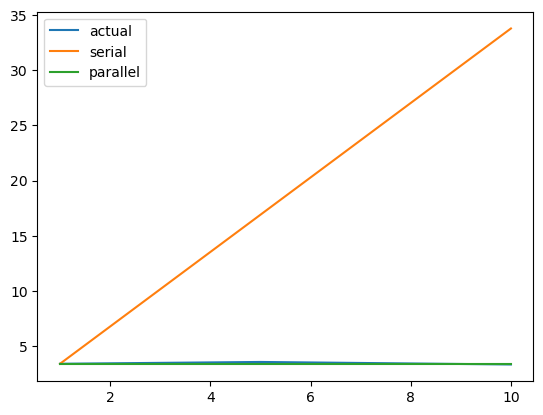

In [36]:
# importing matplotlib module
from matplotlib import pyplot as plt

# Function to plot
plt.plot(execution_times.keys(),
         list(
             zip(execution_times.values(), [execution_times[1] * x for x in execution_times.keys()],
                 [execution_times[1] for _ in execution_times.keys()])),
         label=["actual", "serial", "parallel"])
plt.legend()

# function to show the plot
plt.show()

### 3.3 - Event Driven Pipeline: Creating a Microservice

In a true production environment, the CVE scans would be triggered by some other event, such as a new container being uploaded into a registry or a new project being created. In this section, we will show how to create a microservice that can be triggered by an event and run the pipeline we built in the previous sections.

Previously, when our pipeline was started, it would read all inputs from a DataFrame and run the pipeline for each input. Once the pipeline was done processing the DataFrame, it would shutdown. To run the pipeline as a microservice, we need to modify the pipeline to run continuously and listen for new inputs on an HTTP endpoint.

Fortunately, in Morpheus this is as easy as changing out the type of source that is used in the pipeline. The code below is identical to the previous pipeline except we have changed the source from `InMemorySourceStage` to `HttpServerSourceStage`. The `HttpServerSourceStage` class listens for new inputs on an HTTP endpoint and passes them to the next stage in the pipeline. It pulls the inputs from the request body and passes them to the pipeline to be processed.

Additionally, right after the `HttpServerSourceStage` we have added a simple custom stage to the pipeline `print_payload`. This custom stage simply prints the payload that was passed to the pipeline. This is useful for debugging and seeing exactly when the pipeline was triggered since the results may take time to process and be shown to the console.


In [37]:
# Code for creating a microservice
from cyber_dev_day.pipeline_utils import build_cve_llm_engine

from morpheus.messages import ControlMessage
from morpheus.messages import MessageMeta
from morpheus.pipeline.linear_pipeline import LinearPipeline
from morpheus.pipeline.stage_decorator import stage
from morpheus.stages.input.http_server_source_stage import HttpServerSourceStage
from morpheus.stages.llm.llm_engine_stage import LLMEngineStage
from morpheus.stages.output.in_memory_sink_stage import InMemorySinkStage
from morpheus.stages.preprocess.deserialize_stage import DeserializeStage
from morpheus.utils.concat_df import concat_dataframes
from morpheus.utils.http_utils import HTTPMethod


async def run_cve_pipeline_microservice(p_config: Config, e_config: EngineConfig):

    completion_task = {"task_type": "completion", "task_dict": {"input_keys": ["cve_info"], }}

    pipe = LinearPipeline(p_config)

    # Use an HTTP source to listed for requests. The expected payload is:
    # [{"cve_info": <sting>},
    #  {"cve_info": <sting>},]
    pipe.set_source(
        HttpServerSourceStage(p_config, bind_address="0.0.0.0", port=26302, endpoint="/scan", method=HTTPMethod.POST))

    # To see when our pipeline has been triggered, add a simple logging stage to print the payload
    @stage
    def print_payload(payload: MessageMeta) -> MessageMeta:
        serialized_str = payload.df.to_json(orient='records', lines=True)

        logger.info("======= Got Request =======\n%s\n===========================", serialized_str)

        return payload

    pipe.add_stage(print_payload(config=p_config))

    # The remaineder of the pipeline is identical to the previous example
    pipe.add_stage(
        DeserializeStage(p_config, message_type=ControlMessage, task_type="llm_engine", task_payload=completion_task))

    pipe.add_stage(LLMEngineStage(p_config, engine=build_cve_llm_engine(e_config)))

    sink = pipe.add_stage(InMemorySinkStage(p_config))

    await pipe.run_async()

    messages = sink.get_messages()
    responses = concat_dataframes(messages)

    logger.info("Pipeline complete")

    logger.info("Pipeline complete. Received %s responses:\n%s", len(messages), responses['response'])

Finally, we can start our microservice by running the pipeline as we have in the past. While the pipeline is running, move on to the next section to see how to trigger the pipeline with an HTTP request.

<div class="alert alert-block alert-warning">
<b>Note:</b> When executed, the following cell will run indefinitely. You will need to interrupt the kernel to stop it. 
</div>


In [50]:
await run_cve_pipeline_microservice(pipeline_config, engine_config_custom_model)

====Pipeline Pre-build====
====Pre-Building Segment: linear_segment_0====
====Pre-Building Segment Complete!====
====Pipeline Pre-build Complete!====
====Registering Pipeline====
====Building Pipeline====
====Building Pipeline Complete!====
====Registering Pipeline Complete!====
====Starting Pipeline====
====Pipeline Started====
====Building Segment: linear_segment_0====
Added source: <from-http-37; HttpServerSourceStage(bind_address=0.0.0.0, port=26302, endpoint=/scan, method=HTTPMethod.POST, accept_status=201, sleep_time=0.1, queue_timeout=5, max_queue_size=None, num_server_threads=None, max_payload_size=10, request_timeout_secs=30, lines=False, stop_after=0)>
  └─> morpheus.MessageMeta
Added stage: <print_payload-38; WrappedFunctionStage(name=print_payload, on_data_fn=functools.partial(<function run_cve_pipeline_microservice.<locals>.print_payload at 0x7f71e4127370>), accept_type=<class 'morpheus.messages.message_meta.MessageMeta'>, compute_schema_fn=<function stage.<locals>.wrapper

I20240315 17:50:28.699340  2768 asyncio_runnable.hpp:246] AsyncioRunnable::run() > Creating new event loop
I20240315 17:50:28.700188  2768 asyncio_runnable.hpp:259] AsyncioRunnable::run() > Calling run_until_complete() on main_task()


======= Got Request =======
{"cve_info":"An issue was discovered in the Linux kernel through 6.0.9. drivers\/media\/dvb-core\/dvbdev.c has a use-after-free, related to dvb_register_device dynamically allocating fops."}



/tmp/ipykernel_407/2223737218.py:31: DeprecationWarning: Warning the df property returns a copy, please use the copy_dataframe method or the mutable_dataframe context manager to modify the DataFrame in-place instead.
  serialized_str = payload.df.to_json(orient='records', lines=True)
/opt/conda/envs/morpheus/lib/python3.10/site-packages/cudf/io/json.py:239: UserWarning: Using CPU via Pandas to write JSON dataset
  warnings.warn("Using CPU via Pandas to write JSON dataset")




> Entering new AgentExecutor chain...
I need to check if the Docker container's Linux kernel has the mentioned use-after-free vulnerability in the specified file and function. To do this, I can first use the SBOM Package Checker to see if the Linux kernel is present in the container and get its version number. Then, I can use the Docker Container Code QA System to check if the container's Linux kernel uses the problematic function in the given file.

Action: SBOM Package Checker
Action Input: Linux kernel


Observation: The package Linux kernel

 was not found in the SBOM
Thought:It seems that the SBOM Package Checker did not find the Linux kernel in the Docker container. This might be because the container is using a custom-built kernel or the SBOM is not complete. In any case, without knowing the kernel version, it's impossible to determine if the use-after-free vulnerability is present. I would recommend further investigation into why the Linux kernel is not present in the SBOM or

/tmp/ipykernel_407/2223737218.py:31: DeprecationWarning: Warning the df property returns a copy, please use the copy_dataframe method or the mutable_dataframe context manager to modify the DataFrame in-place instead.
  serialized_str = payload.df.to_json(orient='records', lines=True)
/opt/conda/envs/morpheus/lib/python3.10/site-packages/cudf/io/json.py:239: UserWarning: Using CPU via Pandas to write JSON dataset
  warnings.warn("Using CPU via Pandas to write JSON dataset")




> Entering new AgentExecutor chain...
I need to check if the Docker container's Python version is affected by this vulnerability. To do this, I'll first use the SBOM Package Checker to see if the container has Python installed and determine its version. If the container does have Python and its version is before 3.11.4, then it might be vulnerable. However, to confirm the vulnerability, I would need to analyze the application code using the Docker Container Code QA System to see if it uses the urllib.parse component and if it accepts URLs starting with blank characters.

Action: SBOM Package Checker
Action Input: Python

(Waiting for the SBOM Package Checker to return the result)


Observation: The package Python

(Waiting for the SBOM Package Checker to return the result)

 was not found in the SBOM
Thought:Since the SBOM Package Checker did not find the Python package in the Docker container, I cannot determine the Python version installed in the container. Therefore, I cannot conf

#### 3.3.1 - Triggering the Microservice

To trigger the microservice, we will use a CURL request to send a request to the microservice. Since the notebook cannot run commands while the microservice is running, we need to open up a new terminal to send the request. To do that, follow the steps below:

1. In Jupyter Lab, press Ctrl + Shift + L (Shift + ⌘ + L on Mac) to open a new Launcher tab
2. In the Launcher tab, click on the Terminal icon to open a new terminal
3. In the terminal, run the following command to send a request to the microservice:

```bash
curl --request POST \
  --url http://localhost:26302/scan \
  --header 'Content-Type: application/json' \
  --data '[{
      "cve_info" : "An issue was discovered in the Linux kernel through 6.0.9. drivers/media/dvb-core/dvbdev.c has a use-after-free, related to dvb_register_device dynamically allocating fops."
   }]'
```

4. Once the request is sent, the microservice will process the request and return the results in the terminal
   1. To see the results, switch back to the Notebook tab. You should see that the microservice received your request and started processing it.
   ```
   I20240308 16:00:56.422039 3010283 http_server.cpp:129] Received request: POST : /scan
   ```
   2. It helps to have the terminal and the notebook side by side so you can see the results in the terminal as they come in. To do this, click on the terminal tab and drag it to the right side of the screen. You should then be able to see the terminal and the notebook side by side similar to the image below:
      ![Terminal and Notebook Side by Side](./images/side_by_side.png)
5. To stop the microservice, interrupt the kernel by pressing the stop button in the toolbar
